# Part a): Write your own Stochastic Gradient Descent code, first step
In order to get started, we will now replace in our standard ordinary least squares (OLS) and Ridge regression codes (from project 1) the matrix inversion algorithm with our own gradient descent (GD) and SGD codes. You can use the Franke function or the terrain data from project 1. However, we recommend using a simpler function like a higher-order one-dimensional polynomials. You can obviously test your final codes against for example the Franke function.

The exercise set for week 41 should help in solving this part of the project.

You should include in your analysis of the GD and SGD codes the following elements

In [35]:


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams.update({'text.usetex': True, 'font.size': 18, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 16, 'ytick.labelsize': 16})
import numpy as np
from RegressionModel import RegressionModel
from franke_example import FrankeFunction
from tqdm import tqdm
seed = 40
np.random.seed(seed)

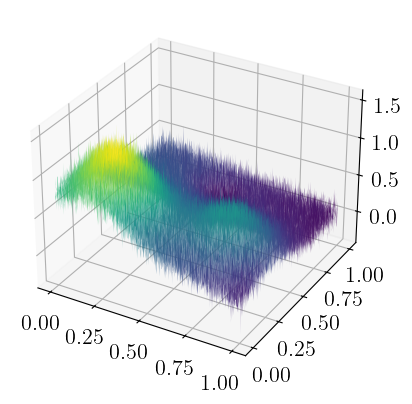

In [36]:
N  = 1000
x = np.arange(0, 1, 1/N).reshape(-1, 1)
y = np.arange(0, 1, 1/N).reshape(-1, 1)
X, Y = np.meshgrid(x, y)

noise = np.random.normal(0, 0.1, (N, N))
# noise = 0

z = (FrankeFunction(X, Y) + noise).reshape(-1, 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z.reshape(N, N), cmap='viridis')
plt.show()

#### 1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression for the gradient.

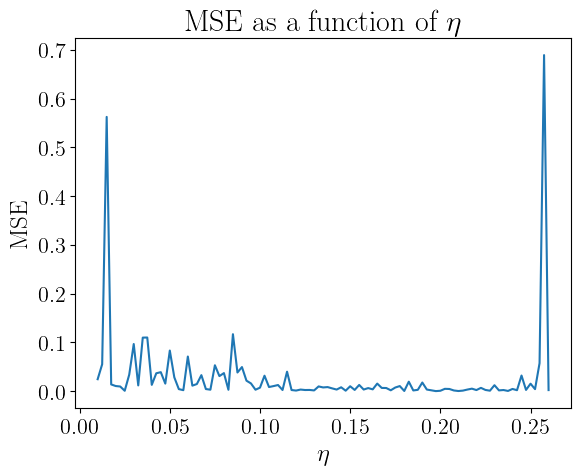

Minimum MSE: 5.9950611892832735e-05


In [37]:
degree = 4
test_size = 0.2
model = RegressionModel(x, y, degree, test_size, seed=seed)
MSE_array= []
η_list = np.linspace(0.01, 0.26, 101)
for η in η_list:
    MSE, R2 = model.gradient_descent(50, eta=η)
    MSE_array.append(MSE)
plt.plot(η_list, MSE_array)
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of $\eta$')
plt.show()
print(f'Minimum MSE: {min(MSE_array)}')

##### Comment
- The learning rate has a high variability in its effect on the MSE when too low. 
- It stabilizes at around 0.15, and increases sharply when above 0.25 


#### 2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.


In [38]:
γ_list = np.linspace(0.6, 0.9, 50)
η_list = np.linspace(0.1, 0.2, 50)
MSE_array = np.zeros((len(η_list), len(γ_list)))
for i, η in enumerate(tqdm(η_list)):
    for j, γ in enumerate(γ_list):
        MSE, R2 = model.gradient_descent(50, gamma=γ, eta=η)
        MSE_array[i, j] = MSE

100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


##### Tuning both the learning rate and the momentum parameter

Minimum MSE: 8.692262362098468e-07


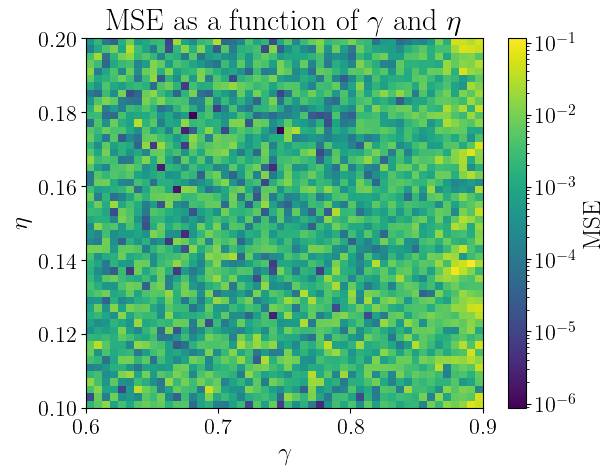

In [39]:
plt.imshow(MSE_array, extent=[γ_list.min(), γ_list.max(), η_list.min(), η_list.max()], aspect='auto', origin='lower', cmap='viridis', norm=mcolors.LogNorm())
plt.colorbar(label='MSE')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\eta$')
plt.title(r'MSE as a function of $\gamma$ and $\eta$')
# plt.show()
# plt.plot(γ_list, MSE_list)
# plt.xlabel(r'$\gamma$')
# plt.ylabel('MSE')
# plt.title(r'MSE as a function of $\gamma$')
# plt.show()

print(f'Minimum MSE: {np.min(MSE_array)}')


##### Tuning the momentum only

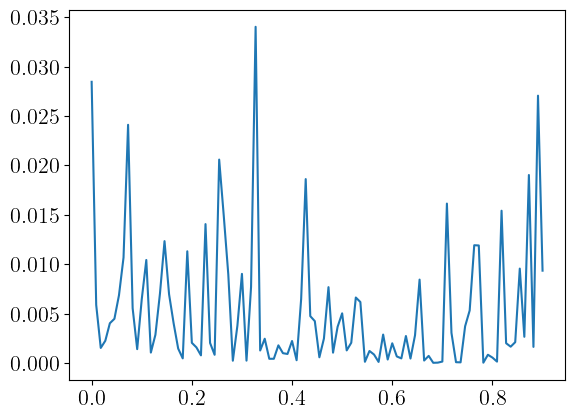

Best MSE: 1.708925653605554e-05
Best γ: 0.6818181818181818


In [40]:
η = 0.15 # using a learning rate of 0.15 should be sufficient
γ_list = np.linspace(0, 0.9, 100)
MSE_list = []
for γ in γ_list:
    MSE, R2 = model.gradient_descent(50, gamma=γ, eta=η)
    MSE_list.append(MSE)
plt.plot(γ_list, MSE_list)
plt.show()
print(f'Best MSE: {min(MSE_list)}')
print(f'Best γ: {γ_list[np.argmin(MSE_list)]}')

 
#### 3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from weeks 39 and 40. Discuss the results as functions of the various parameters (size of batches, number of epochs etc). Use the analytical gradient.


#### 4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.


#### 5. Add RMSprop and Adam to your library of methods for tuning the learning rate.